In [84]:
### Variable a predecir 'Global_active_power'

# Módulos

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

# Lectura de Dataset

In [86]:
df = pd.read_csv('dataset_luzz.csv', sep=';', na_values='?', low_memory=False)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# Series de Tiempo

In [87]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('DateTime', inplace=True)
df = df.sort_index()

df.drop(columns=['Date', 'Time'], inplace=True)
df.drop('Global_intensity', axis=1, inplace=True)

In [88]:
df['Hour'] = df.index.hour           # Hora del día
# df['Weekday'] = df.index.weekday     # Día de la semana
df['Month'] = df.index.month         # (opcional, si analizas estacionalidad)

In [89]:
x = df.drop('Global_active_power', axis=1)
y = df['Global_active_power']

# Gráficas

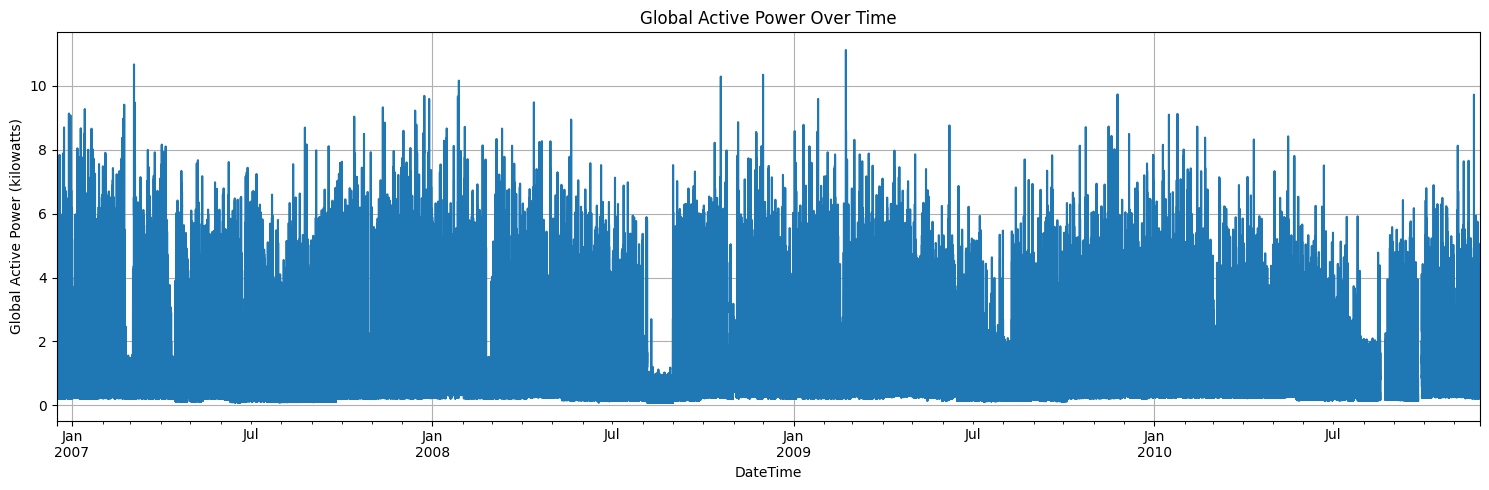

In [90]:
plt.figure(figsize=(15, 5))
df['Global_active_power'].plot()
plt.title('Global Active Power Over Time')
plt.xlabel('DateTime')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Promedio diario de Global Active Power'}, xlabel='DateTime'>

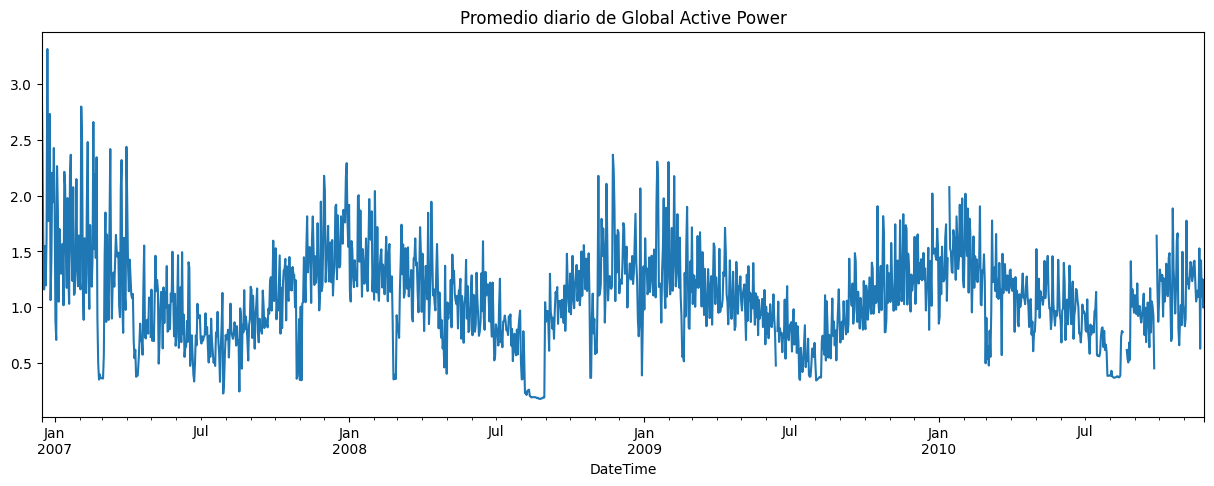

In [91]:
daily_avg = df['Global_active_power'].resample('D').mean()
daily_avg.plot(figsize=(15,5), title='Promedio diario de Global Active Power')

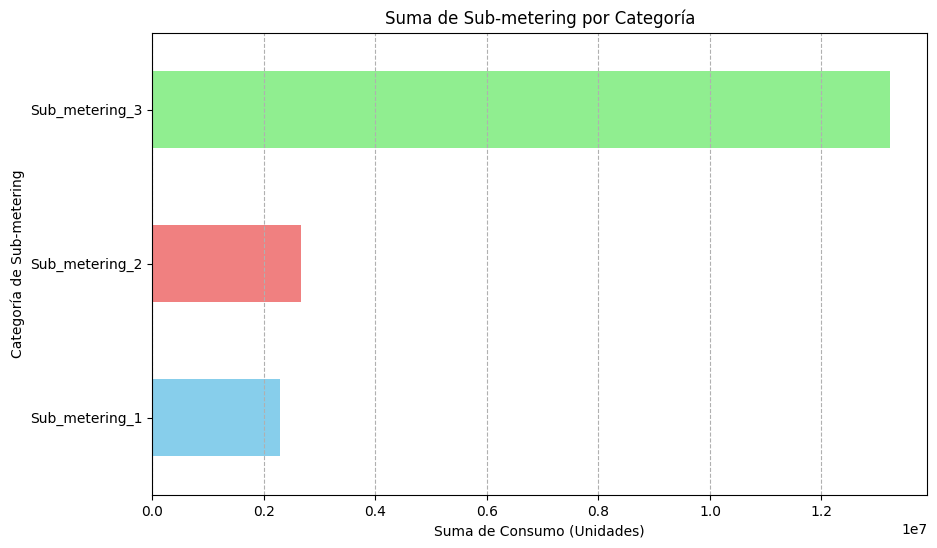

In [92]:
# Seleccionar las columnas de interés
sub_metering_cols = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Calcular la suma de los valores para cada columna
sub_metering_sums = df[sub_metering_cols].sum()

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6)) # Ajusta el tamaño si es necesario
sub_metering_sums.plot(kind='barh', color=['skyblue', 'lightcoral', 'lightgreen'])

plt.title('Suma de Sub-metering por Categoría')
plt.xlabel('Suma de Consumo (Unidades)')
plt.ylabel('Categoría de Sub-metering')
plt.grid(axis='x', linestyle='--') # Añade una cuadrícula en el eje x
plt.show()

# Sub_metering_3; Corresponde a un calentador de agua eléctrico y un aire acondicionado.
# Sub_metering_2; Corresponde al lavadero, que contiene lavadora, secadora, refrigerador y luz.
# Sub_metering_1; Corresponde a la cocina, que contiene principalmente lavavajillas, horno y microondas (las placas eléctricas no son eléctricas, sino de gas).

# Datos nulos

In [93]:
cols_to_impute = df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

In [94]:
df_imputed_median = df.copy() 

for col in cols_to_impute:
    median_val = df_imputed_median[col].median()
    df[col] = df_imputed_median[col].fillna(median_val)

In [95]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Hour                     0
Month                    0
dtype: int64

In [96]:
# Calcular el punto de división (ej. 80% para entrenamiento, 20% para prueba)
train_size = int(len(df) * 0.8)

# Dividir X y y cronológicamente
x_train = x.iloc[:train_size]
x_test = x.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Tamaño de X_train: {x_train.shape}")
print(f"Tamaño de X_test: {x_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

# Puedes verificar las fechas de inicio/fin de cada conjunto
print(f"Fecha de inicio de train: {x_train.index.min()} / Fecha de fin de train: {x_train.index.max()}")
print(f"Fecha de inicio de test: {x_test.index.min()} / Fecha de fin de test: {x_test.index.max()}")

Tamaño de X_train: (1660207, 7)
Tamaño de X_test: (415052, 7)
Tamaño de y_train: (1660207,)
Tamaño de y_test: (415052,)
Fecha de inicio de train: 2006-12-16 17:24:00 / Fecha de fin de train: 2010-02-11 15:30:00
Fecha de inicio de test: 2010-02-11 15:31:00 / Fecha de fin de test: 2010-11-26 21:02:00


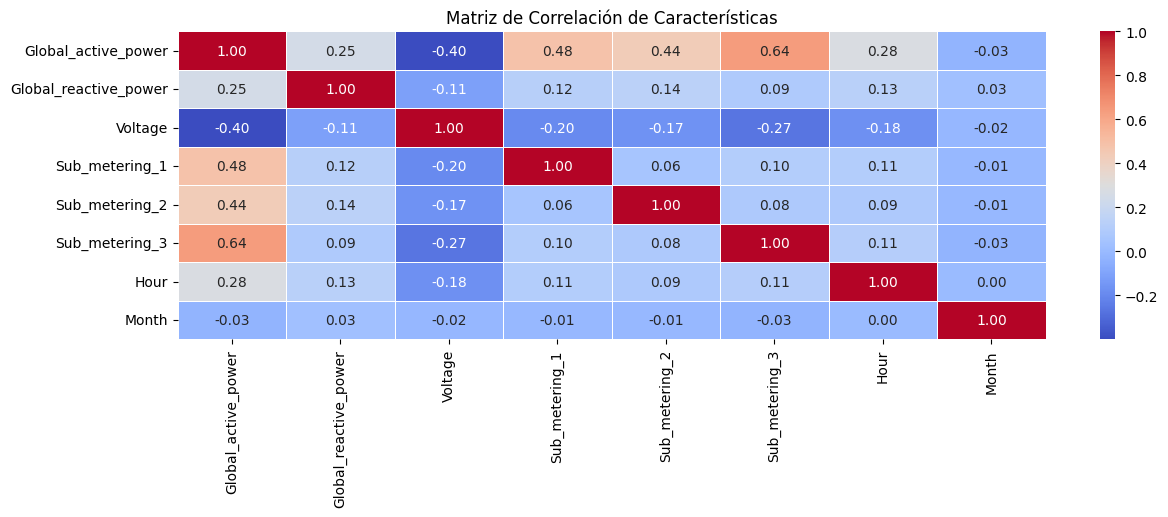

In [97]:
correlation_matrix = df.corr()

plt.figure(figsize=(14, 4)) # Ajusta el tamaño para que sea legible
sns.heatmap(correlation_matrix, 
            annot=True,     # Muestra los valores de correlación en las celdas 
            cmap='coolwarm',# Define el esquema de color (ej. 'coolwarm', 'viridis', 'RdBu')
            fmt=".2f",      # Formato de los números a dos decimales
            linewidths=.5)  # Espacio entre las celdas

plt.title('Matriz de Correlación de Características')
plt.show()

# Outliers

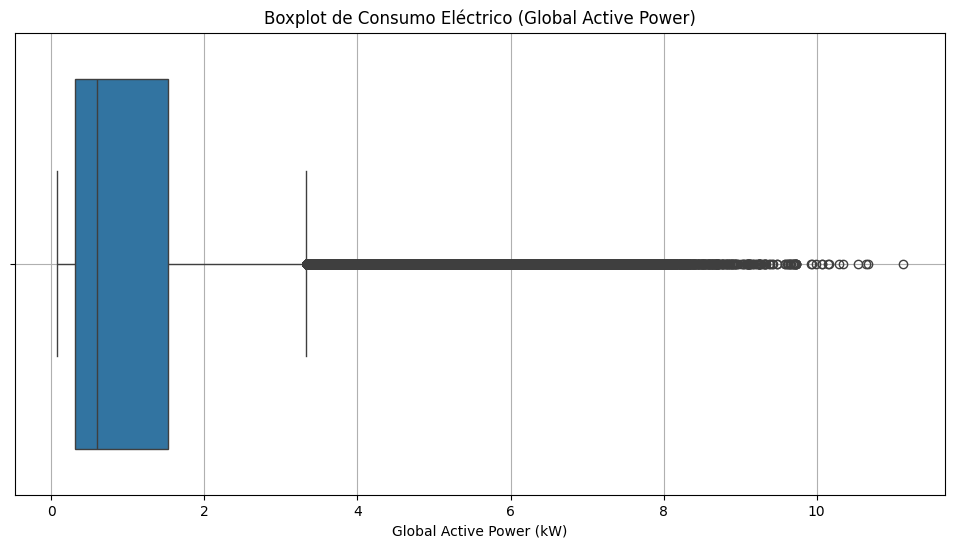

In [98]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Global_active_power'])
plt.title('Boxplot de Consumo Eléctrico (Global Active Power)')
plt.xlabel('Global Active Power (kW)')
plt.grid(True)
plt.show()

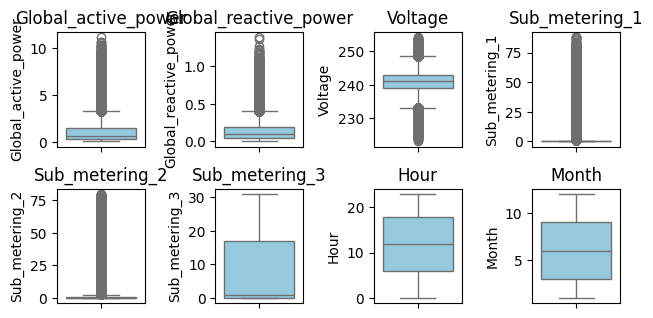

In [99]:
# Crear un subplot por cada columna numérica
for i, column in enumerate(df.select_dtypes(include='number').columns, 1):
    plt.subplot(3, 4, i)  # Ajusta filas y columnas según columnas
    sns.boxplot(y=df[column], color='skyblue')
    plt.title(column)

plt.tight_layout()
plt.show()

In [100]:
for column in df.select_dtypes(include='number').columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    outliers = df[(df[column] < Q1 - 1.5 * IQR) |
                  (df[column] > Q3 + 1.5 * IQR)]

    print(f"Columna '{column}': {len(outliers)} outliers")


Columna 'Global_active_power': 96742 outliers
Columna 'Global_reactive_power': 42234 outliers
Columna 'Voltage': 54737 outliers
Columna 'Sub_metering_1': 169105 outliers
Columna 'Sub_metering_2': 77151 outliers
Columna 'Sub_metering_3': 0 outliers
Columna 'Hour': 0 outliers
Columna 'Month': 0 outliers


In [101]:
# Eliminar solo las filas que contienen valores nulos

x_train = x_train.dropna()
x_test = x_test.dropna()
y_train = y_train.dropna()
y_test = y_test.dropna()

# Escalar Datos (RL)

In [ ]:
original_x_test_index = x_test.index
original_y_train_index = y_train.index # Guardamos como índice para después graficar
original_y_test_index = y_test.index

In [102]:
scaler_x = StandardScaler()
x_train_lr = scaler_x.fit_transform(x_train)  # SOLO datos pasados
x_test_lr = scaler_x.transform(x_test)        # Aplicar misma transformación


"""
# Escalado de Y
scaler_y = StandardScaler()

# Redimensionar y_train para que sea un array 2D
y_train_reshaped = y_train.values.reshape(-1, 1) # Necesario para StandardScaler
y_train_lr = scaler_y.fit_transform(y_train_reshaped)

y_test_reshaped = y_test.values.reshape(-1,1)
y_test_lr = scaler_y.fit_transform(y_test_reshaped)
"""

# Regresión Lineal

In [107]:
model = LinearRegression()
model.fit(x_train_lr, y_train)

print(f"Coeficientes: {model.coef_}")
print(f"Intercepción (Bias): {model.intercept_}")

Coeficientes: [ 0.09130922 -0.10549154  0.39929954  0.36535405  0.56471939  0.13677253
 -0.01900305]
Intercepción (Bias): 1.112621734977028


In [108]:
# Realizar predicciones sobre el conjunto de prueba
y_pred = model.predict(x_test_lr)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Raíz del error cuadrático medio
r2 = r2_score(y_test, y_pred)

print(f"\nError Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R^2): {r2:.4f}")

# Un R^2 cercano a 1 indica que el modelo explica bien la varianza.
# Un RMSE más bajo es mejor.


Error Cuadrático Medio (MSE): 0.1532
Raíz del Error Cuadrático Medio (RMSE): 0.3914
Coeficiente de Determinación (R^2): 0.8058


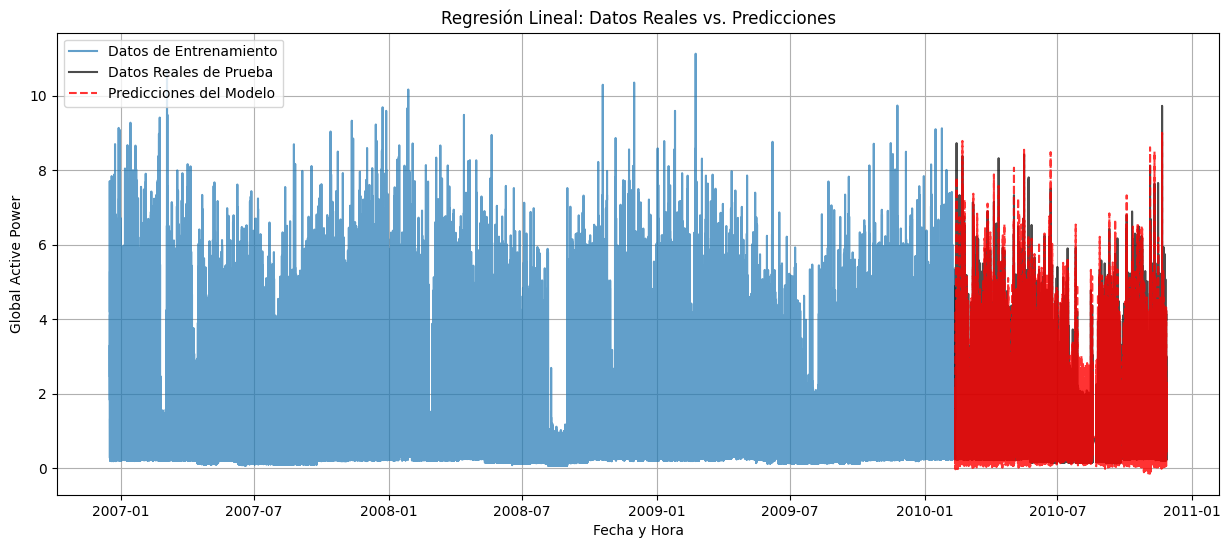

In [109]:
# Convertir y_pred a una serie de Pandas con el índice de X_test para facilitar la graficación
y_pred_series = pd.Series(y_pred, index=x_test.index)

plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Datos de Entrenamiento', alpha=0.7)
plt.plot(y_test.index, y_test, label='Datos Reales de Prueba', color='black', alpha=0.7)
plt.plot(y_pred_series.index, y_pred_series, label='Predicciones del Modelo', color='red', linestyle='--', alpha=0.8)
plt.title('Regresión Lineal: Datos Reales vs. Predicciones')
plt.xlabel('Fecha y Hora')
plt.ylabel('Global Active Power')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Decision Tree Regressor

In [ ]:
# Entrenar árbol de decisión
tree_model = DecisionTreeRegressor(max_depth=11, random_state=42, min_samples_leaf=120, min_samples_split=380, criterion="absolute_error")
tree_model.fit(x_train, y_train)

# Predecir
y_pred_tree = tree_model.predict(x_test)

# Evaluar
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"MSE: {mse_tree:.4f}, R²: {r2_tree:.4f}")

In [ ]:
# Convertir y_pred a una serie de Pandas con el índice de X_test para facilitar la graficación
y_pred_series_tree = pd.Series(y_pred_tree, index=x_test.index)

plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Datos de Entrenamiento', alpha=0.7)
plt.plot(y_test.index, y_test, label='Datos Reales de Prueba', color='black', alpha=0.7)
plt.plot(y_pred_series_tree.index, y_pred_series_tree, label='Predicciones del Modelo DTC', color='red', linestyle='--', alpha=0.8)
plt.title('DecissionTreeRegressor: Datos Reales vs. Predicciones')
plt.xlabel('Fecha y Hora')
plt.ylabel('Global Active Power')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()